# 0. Load parameters


In [1]:
# | tags: [parameters]
subject = "103"

In [2]:
#| tags: [parameters]
# Injected Parameters
subject = 151


In [3]:
from datetime import datetime


def print_date_time():
    now = datetime.now()
    # Convert the date and time to a string
    now_str = now.strftime("%Y-%m-%d %H:%M:%S")

    # Print the date and time
    print(now_str)

In [4]:
import mne
import autoreject
from autoreject import AutoReject
from autoreject import get_rejection_threshold
from mne.preprocessing import ICA
import toml
import mne_bids
import re
from pathlib import Path
import matplotlib
import numpy as np
from ipywidgets import interact
from mne.preprocessing import ICA

from eeglabio.utils import export_mne_raw

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")


config = toml.load("../../.env.toml")
project_path = config["project"]["path"]

epochs_path = f"{
    project_path}/data/preproc/sub-{subject}/epochs/"
preproc_path = f"{
    project_path}/data/preproc/sub-{subject}/raw/"
path_specparam = f"{
    project_path}/data/preproc/sub-{subject}/"
figure_path = f"{project_path}/analysis/sub-{subject}/figures"


Path(preproc_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

Using matplotlib as 2D backend.


This file contains preprocessing files after downsampling them.


# 2. Work with epochs


In [5]:
# non-filterd epochs ICAs
from mne_icalabel import label_components
from autoreject import get_rejection_threshold  # noqa


def plot_epochs(epochs, stage="epochs", n_epochs=10, n_channels=10, fmax=100.0):
    # plot the data
    epochs_plot = epochs.copy().average().detrend().plot_joint()
    epochs_plot.savefig(
        f"{figure_path}/sub-{subject}_{stage}.png", dpi=300, bbox_inches="tight"
    )
    mne.viz.plot_epochs(
        epochs=epochs,
        picks="eeg",
        show=False,
        n_epochs=n_epochs,
        n_channels=n_channels,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )
    epochs_plot_psd = epochs.compute_psd(
        method="welch", picks="eeg", fmax=100.0, exclude="bads"
    ).plot(average=True, picks="eeg", exclude="bads", show=False)
    epochs_plot_psd.savefig(
        f"{figure_path}/sub-{subject}_{stage}_psd.png", dpi=300, bbox_inches="tight"
    )

In [6]:
def compute_ica(
    eeg_data,
    reject_log=None,
    n_components=0.999,
    method="picard",
    random_state=99,
):
    """Compute ICA on the data without really bad epochs"""
    ica = ICA(
        n_components=n_components,
        random_state=random_state,
        method="picard",
        fit_params=dict(ortho=False, extended=True),
    )
    ica.fit(eeg_data)

    return ica


def label_components_ica(eeg_data, ica):
    """Assign the IC labels"""

    ic_labels = label_components(eeg_data, ica, method="iclabel")
    labels = ic_labels["labels"]
    return labels, ic_labels


def get_values(labels, ic_labels, threshold=0.8):
    """Get the indices of the labels"""
    element_indices = {}
    element_indices["bad_prob_class"] = []
    prababilities = ic_labels["y_pred_proba"]

    for i, element in enumerate(labels):
        if prababilities[i] > 0.8:
            if element not in element_indices:
                element_indices[element] = []
            element_indices[element].append(i)
        else:
            element_indices["bad_prob_class"].append(i)

    # display(element_indices)
    return element_indices


def plot_ica_components(ica, eeg_data, plot_properties=[]):
    """Plot the ICA components"""

    label_components_ica(eeg_data, ica)
    labeled_components = get_values(labels, ic_labels)

    for label, indices in labeled_components.items():
        display(label, indices)
        # ica_plot = ica.plot_sources(
        #    eeg_data, show_scrollbars=False, picks=slice(0, 20))
        ica_plot = ica.plot_sources(eeg_data, show_scrollbars=False, picks=indices)
        ica_plot = ica.plot_components(picks=indices)
        print(indices)
        if plot_properties:
            ica.plot_properties(eeg_data, picks=indices, psd_args={"fmax": 100.0})
    return labeled_components


def plot_removed_components(
    ica,
    eeg_data,
    labeled_components,
    chosen_components=[
        "eye blink",
        "heart beat",
        "line noise",
        "muscle artifact",
        "channel noise",
    ],
):
    exclude = []
    for label, indices in labeled_components.items():
        if label in chosen_components:
            ica_plot = ica.plot_sources(eeg_data, show_scrollbars=False, picks=indices)
            display(label, indices)
            figs = ica.plot_properties(epochs, picks=indices, psd_args={"fmax": 100.0})

            for fig, ind in zip(figs, indices):
                # fig = ica.plot_properties(eeg_data, picks=ind)
                fig.savefig(
                    f"{figure_path}/sub-{subject}_ICA{str(ind).zfill(3)}_{
                        label.replace(" ", "-")}.png",
                    dpi=300,
                    bbox_inches="tight",
                )
            exclude = exclude + indices
    return exclude

In [7]:
epochs = mne.read_epochs(
    f"{epochs_path}/sub-{subject}_drop_bad-epo.fif", preload=True)
ica = compute_ica(epochs, n_components=0.99, method="picard")
labels, ic_labels = label_components_ica(epochs, ica)

Reading /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/epochs/sub-151_drop_bad-epo.fif ...


    Found the data of interest:


        t =       0.00 ...    5000.00 ms


        0 CTF compensation matrices available


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


Fitting ICA to data using 250 channels (please be patient, this may take a while)


Selecting by explained variance: 47 components


Fitting ICA took 6.0s.


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_53152/847513891.py:23: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(eeg_data, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_53152/847513891.py:23: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(eeg_data, ica, method="iclabel")


'bad_prob_class'

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 9,
 10,
 11,
 13,
 15,
 16,
 17,
 18,
 19,
 21,
 24,
 25,
 26,
 29,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


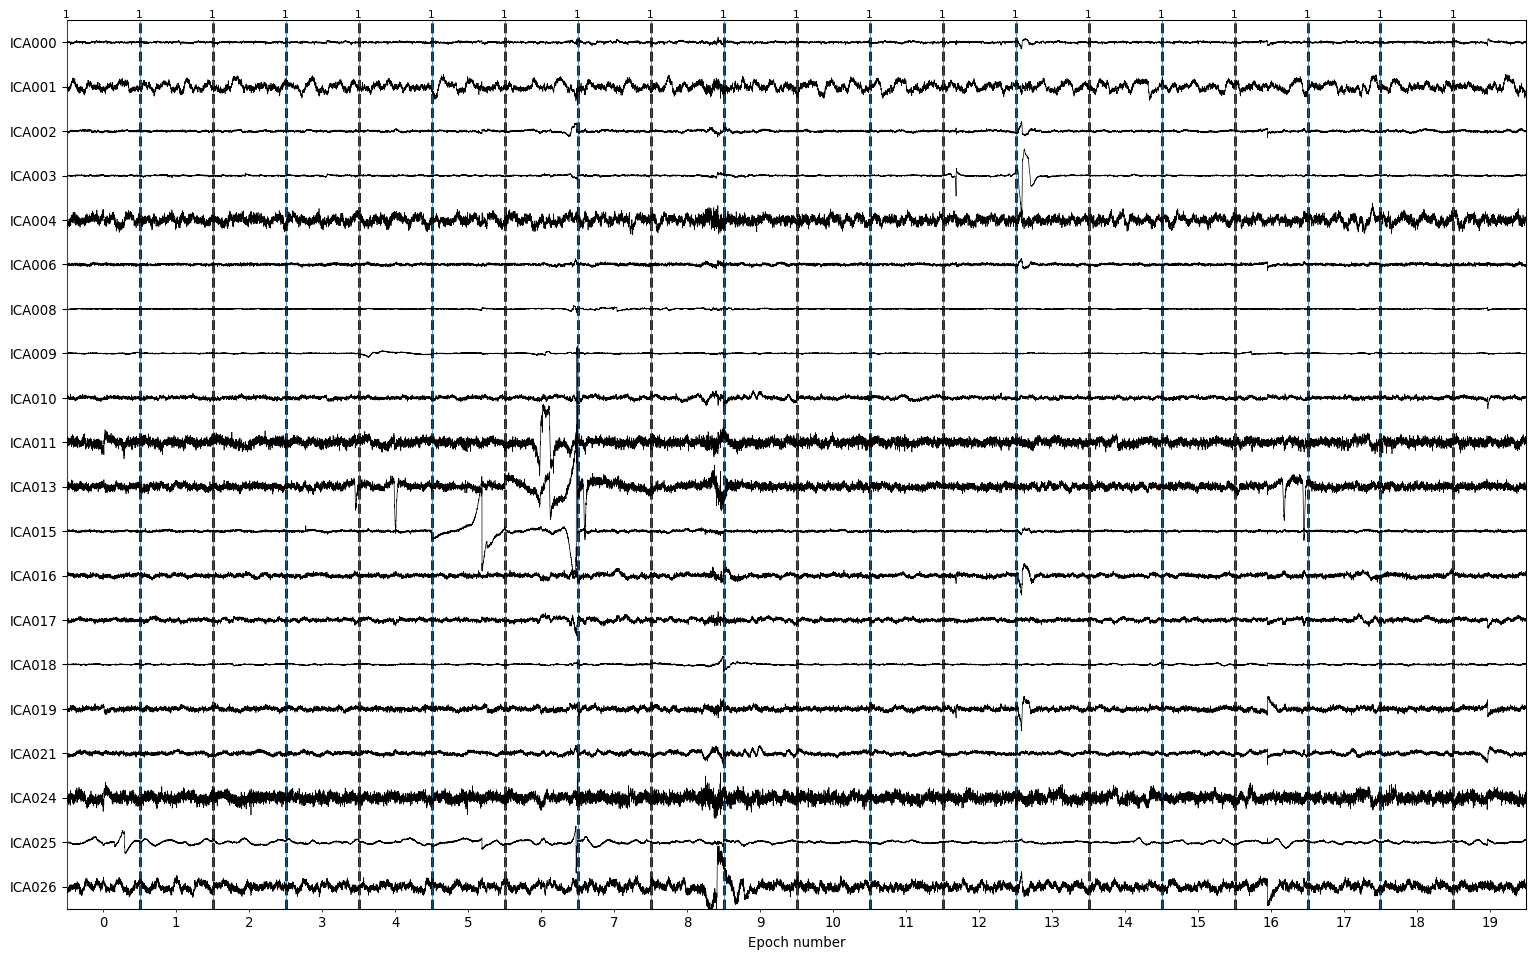

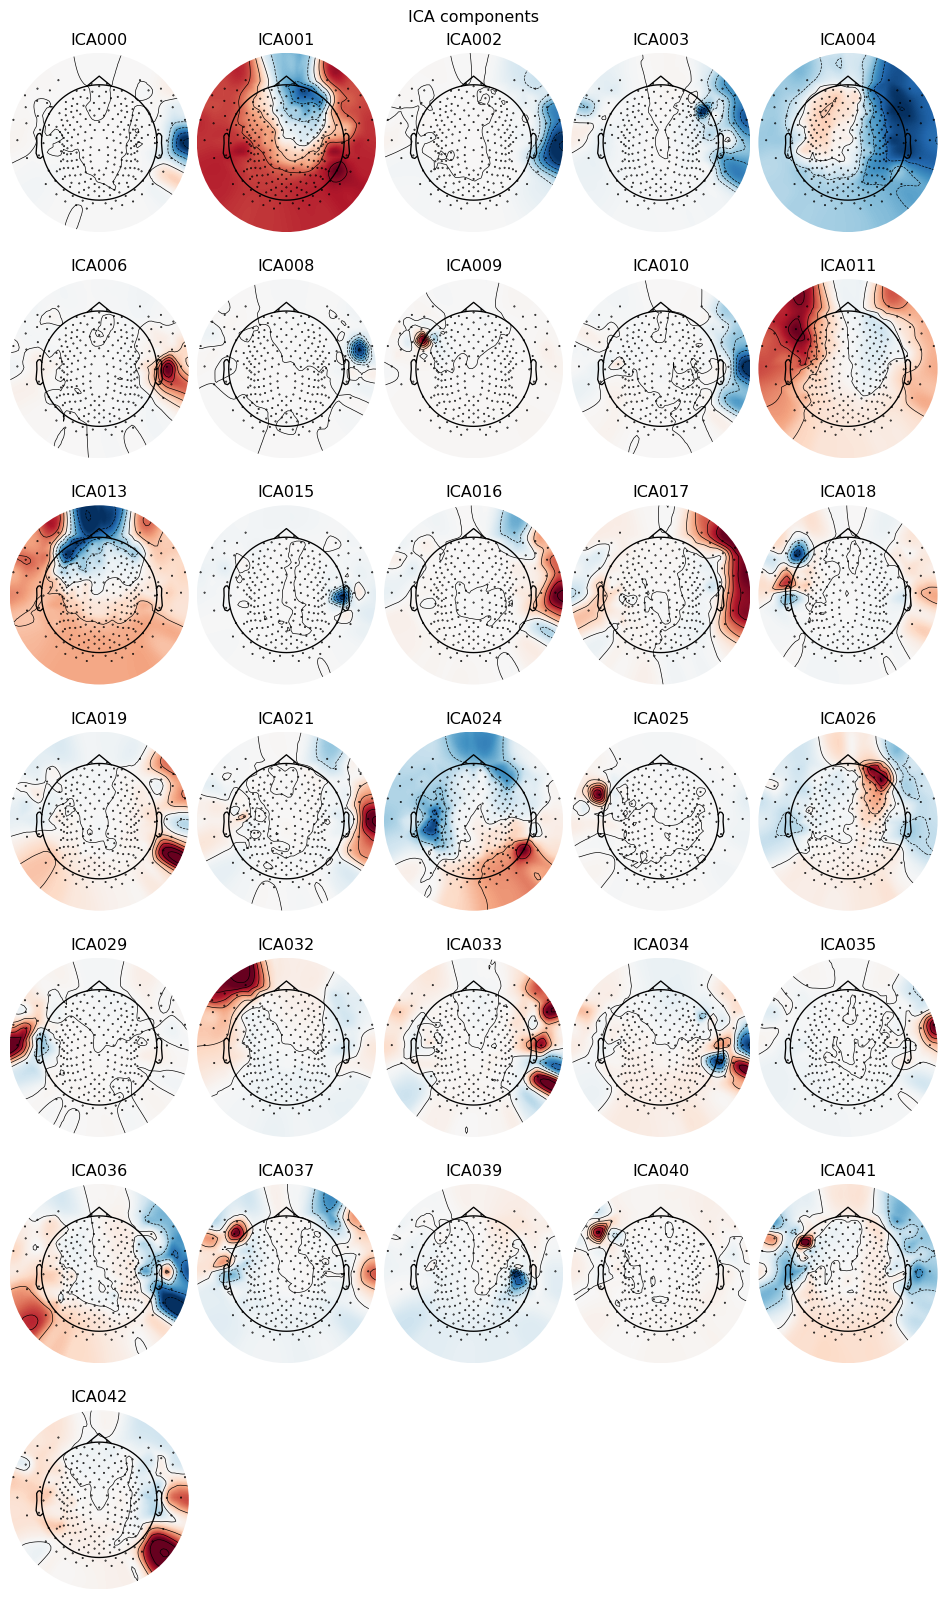

[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 21, 24, 25, 26, 29, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42]


'brain'

[5, 7, 20, 22, 27]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


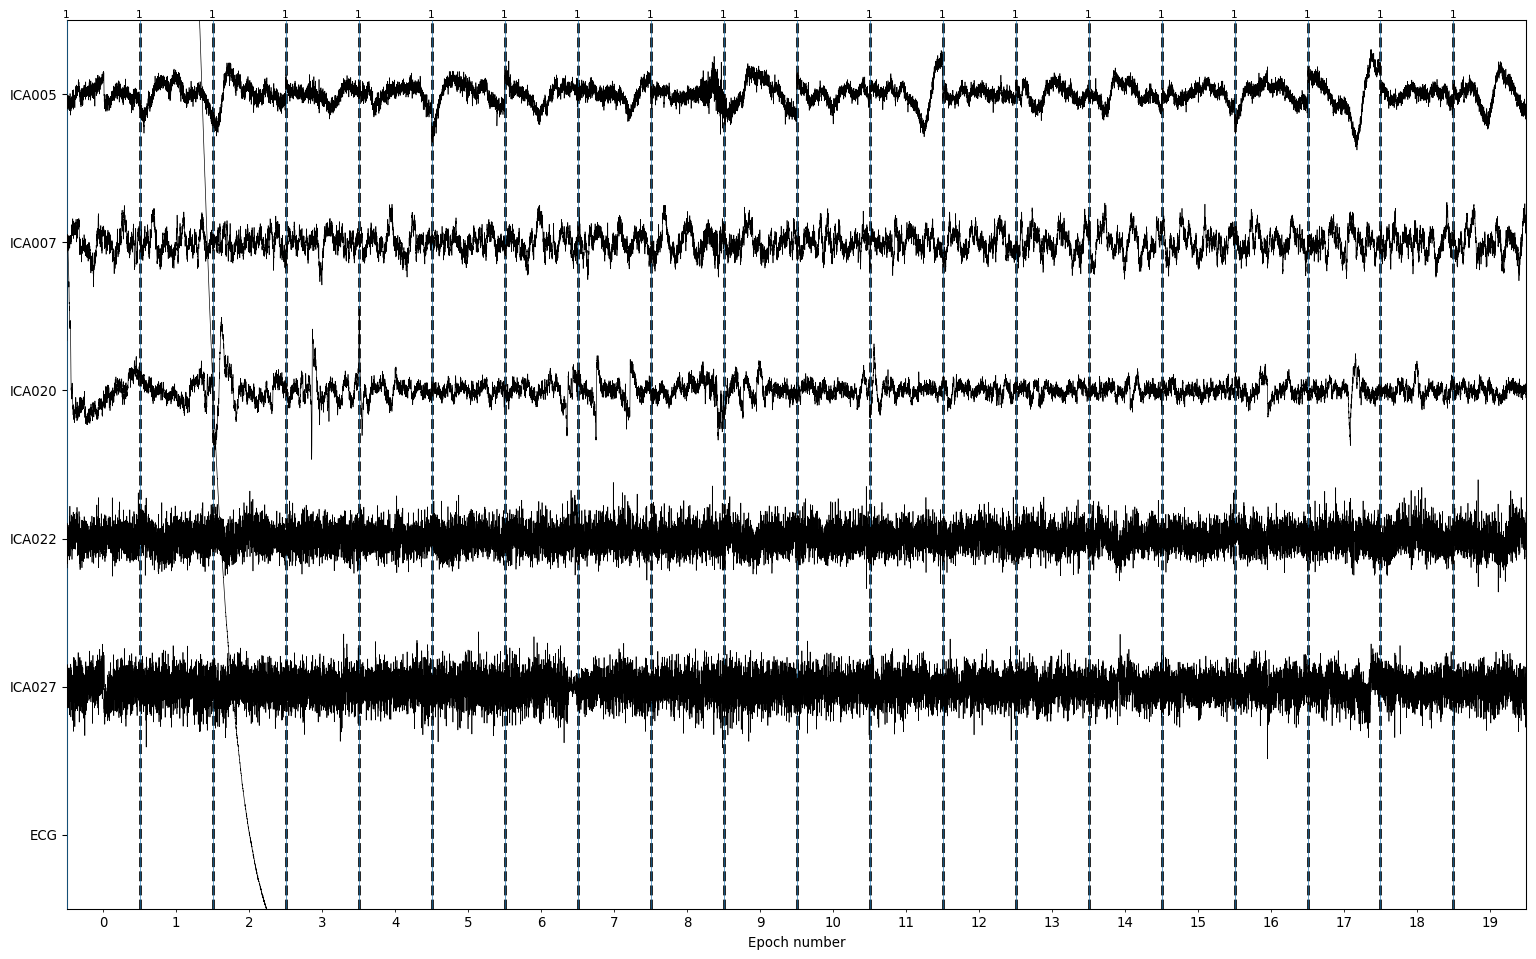

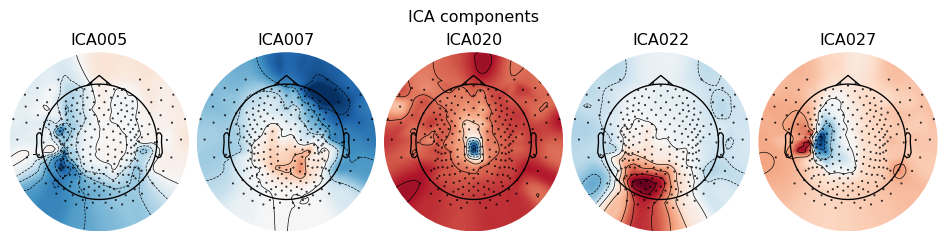

[5, 7, 20, 22, 27]


'channel noise'

[12, 44, 45, 46]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


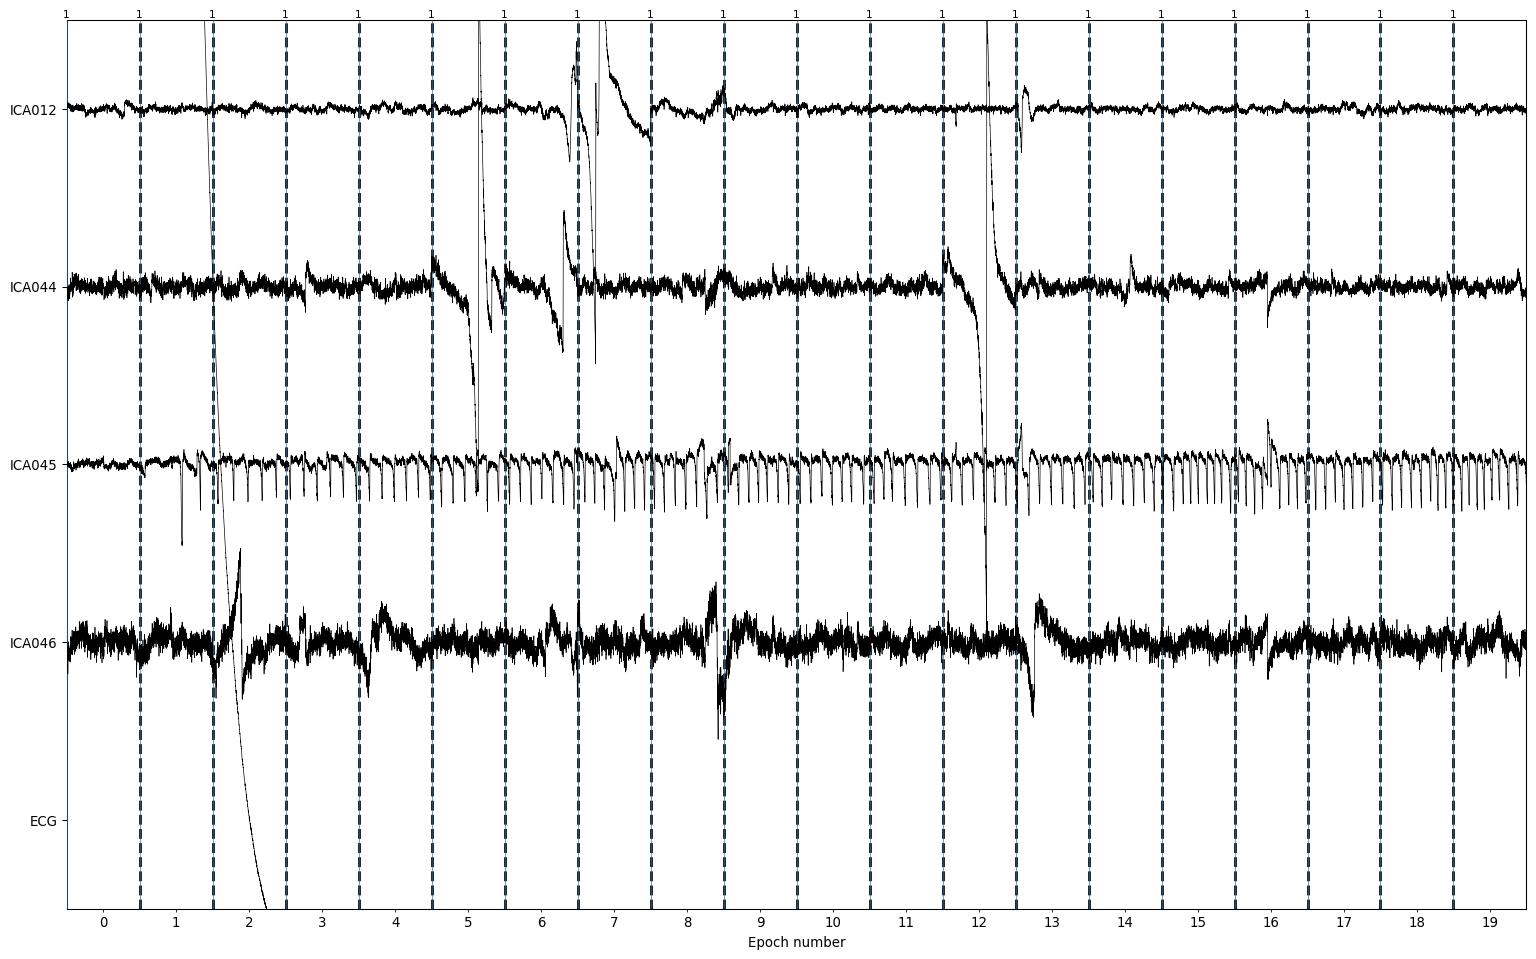

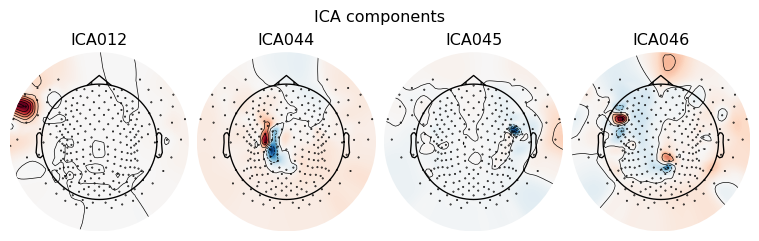

[12, 44, 45, 46]


'muscle artifact'

[14, 30]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


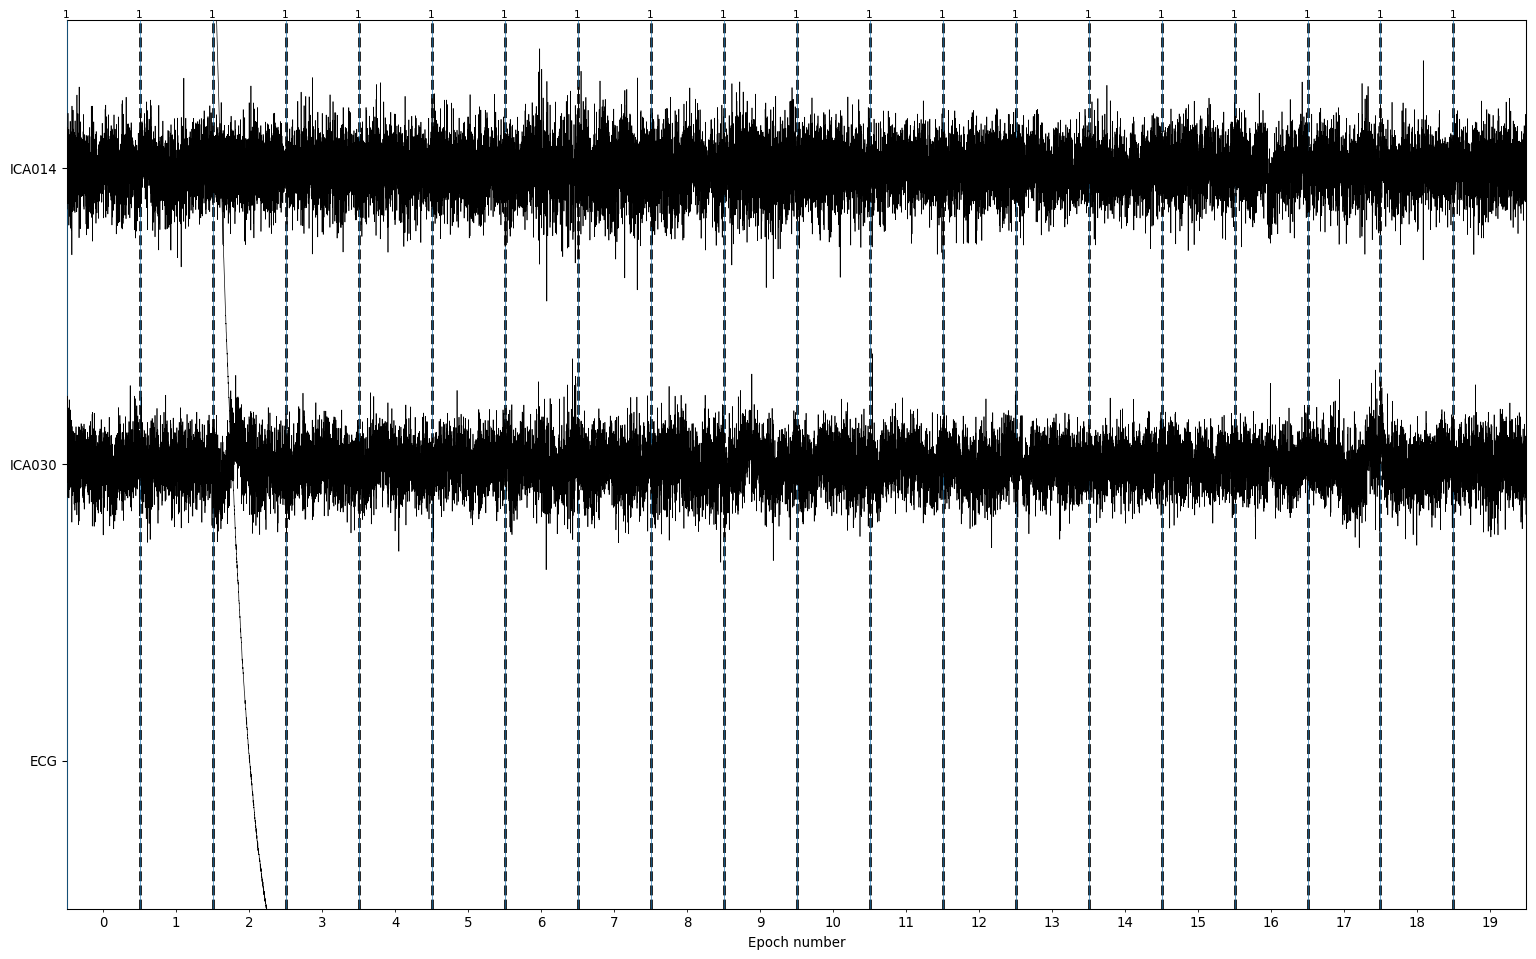

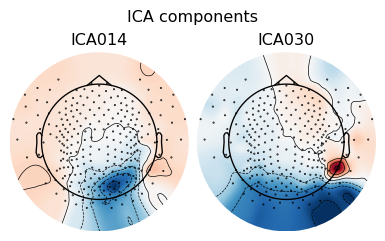

[14, 30]


'other'

[23, 28, 31, 38, 43]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


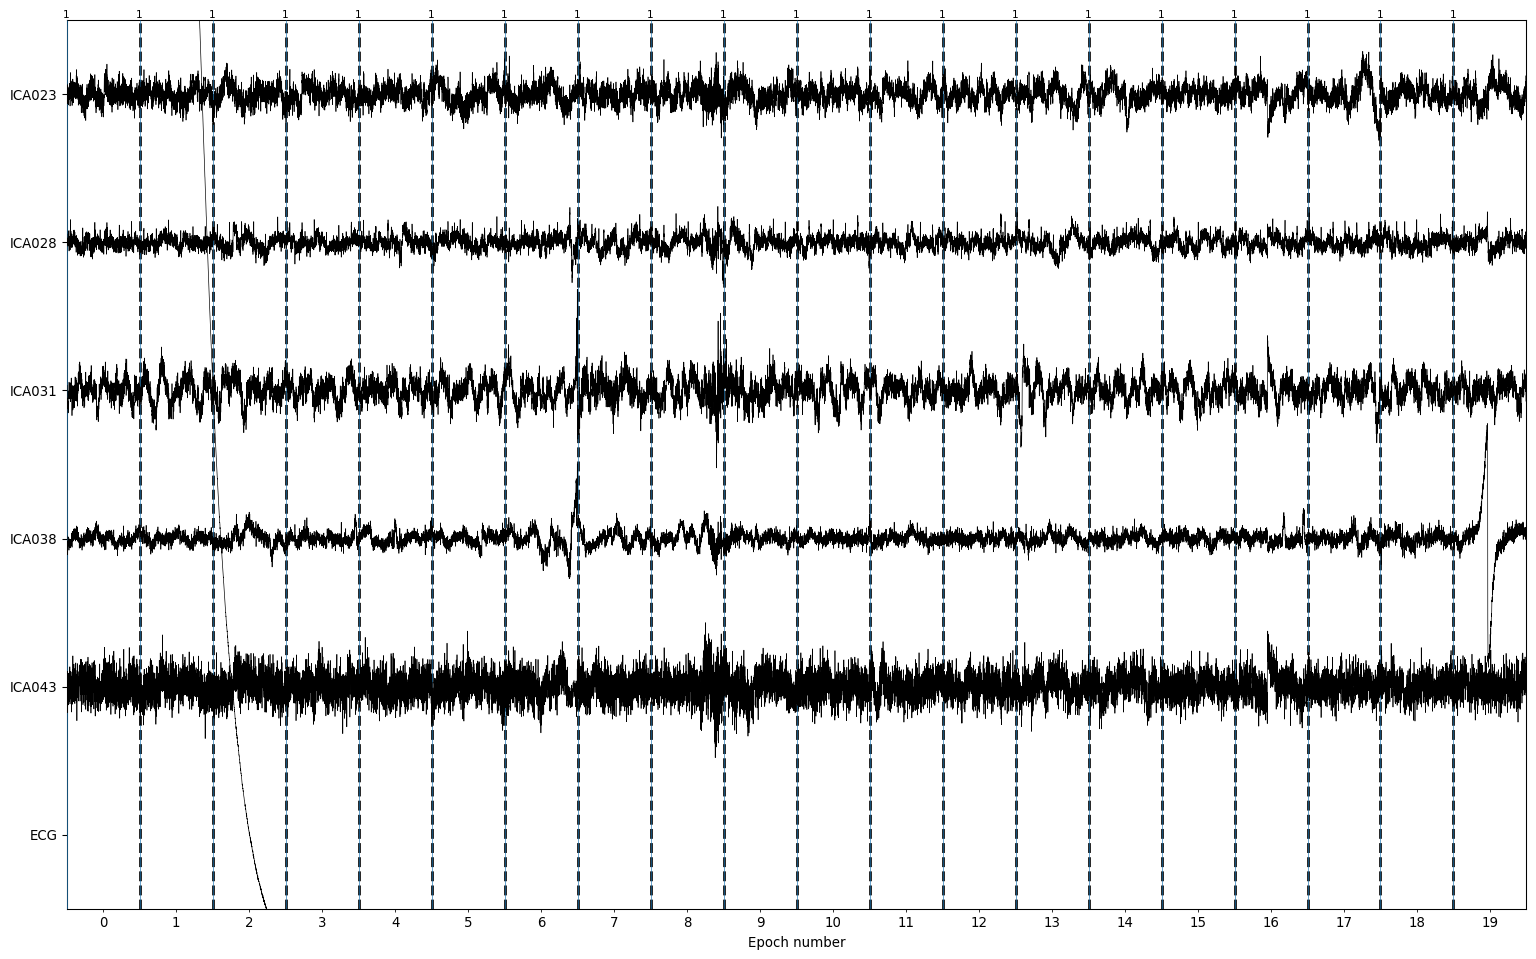

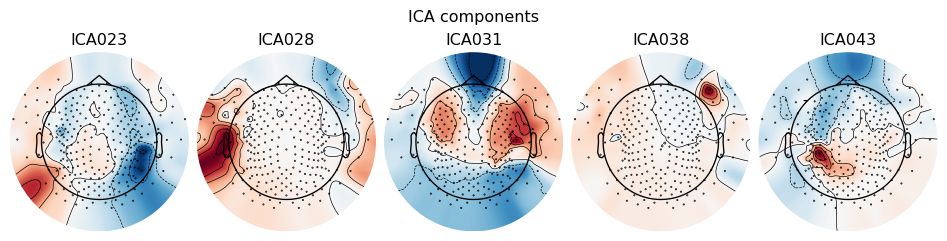

[23, 28, 31, 38, 43]


In [8]:
labeled_components = plot_ica_components(ica, epochs, plot_properties=False)
chosen_components = [
    "eye blink",
    "heart beat",
    "line noise",
    "muscle artifact",
    "channel noise",
]

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


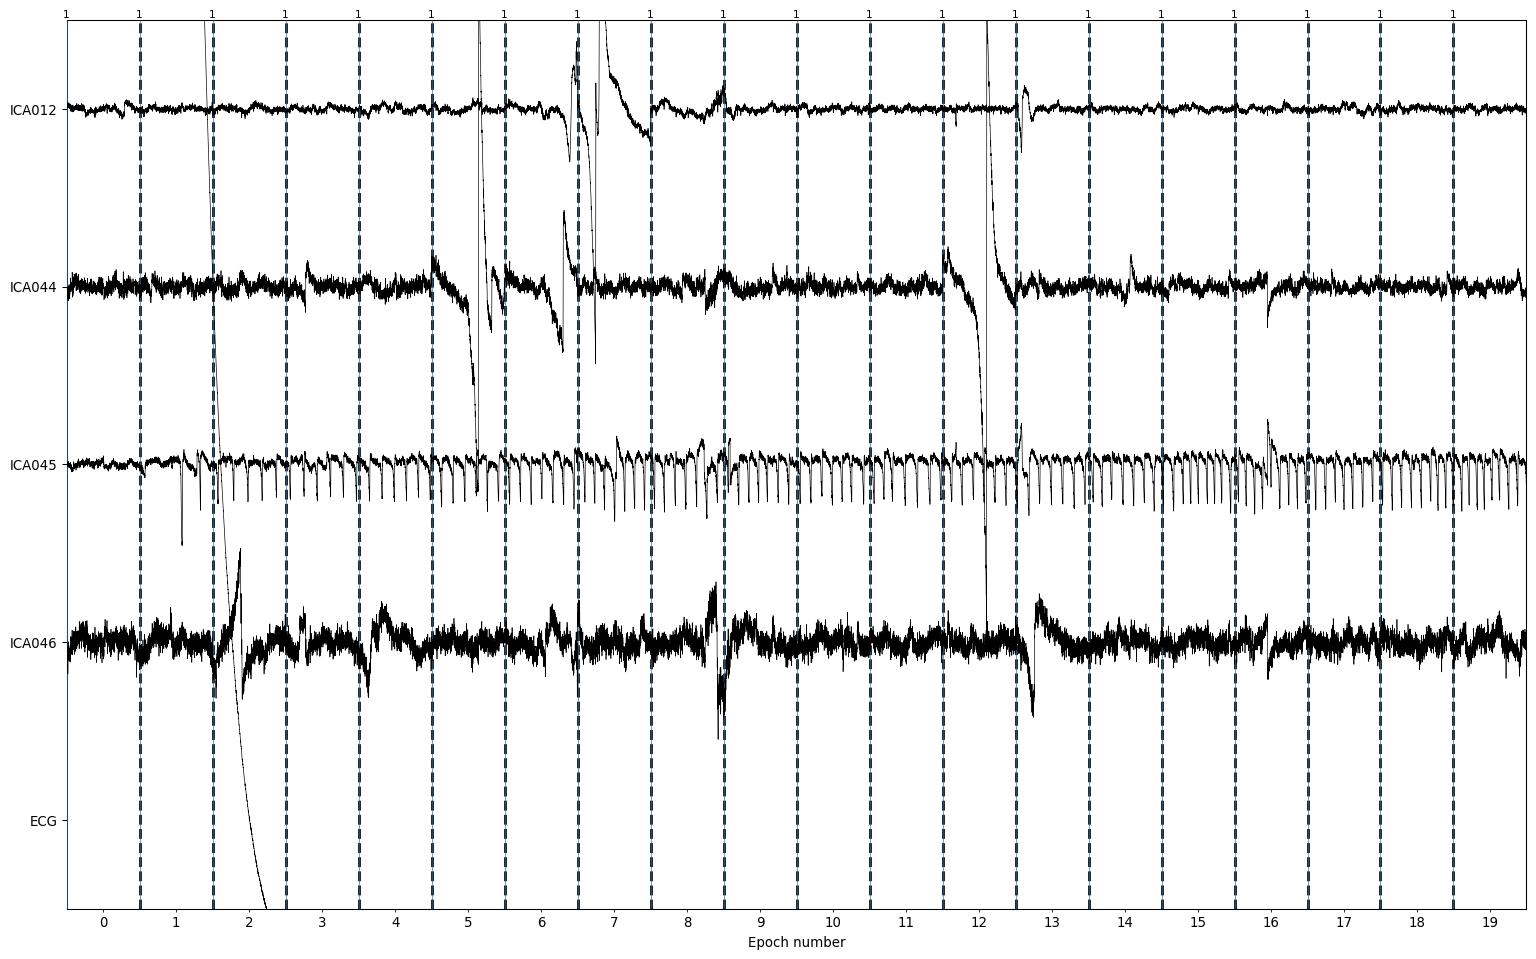

'channel noise'

[12, 44, 45, 46]

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


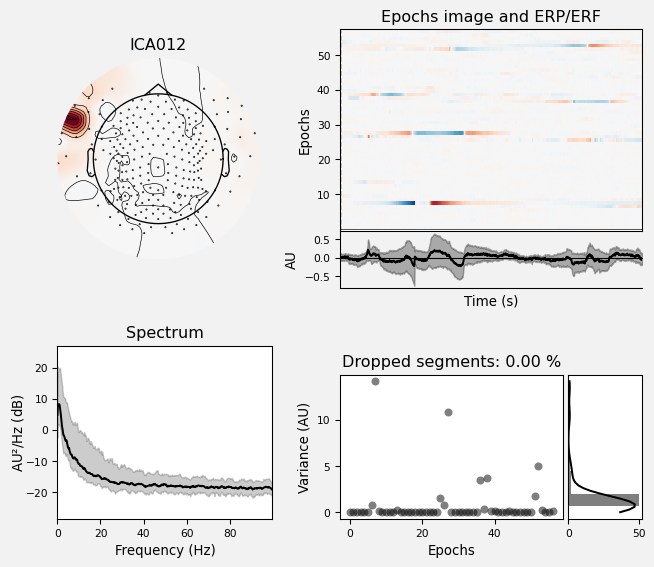

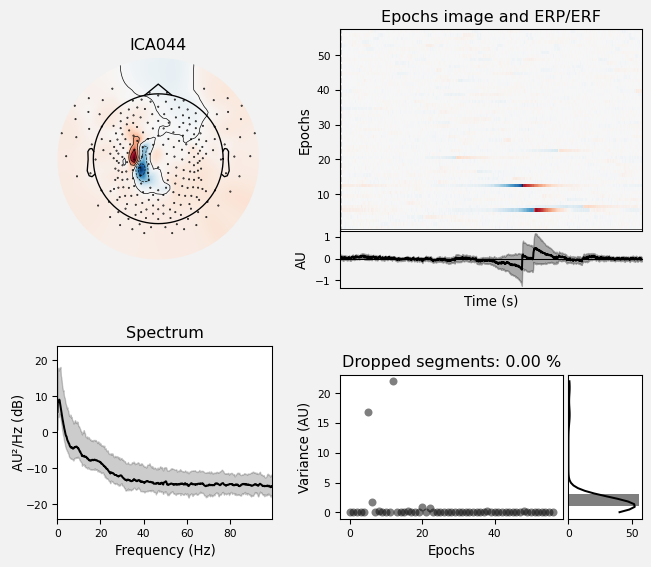

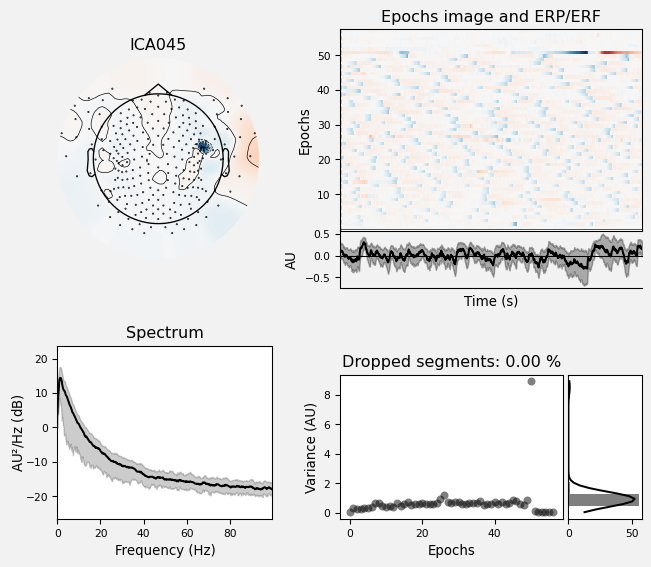

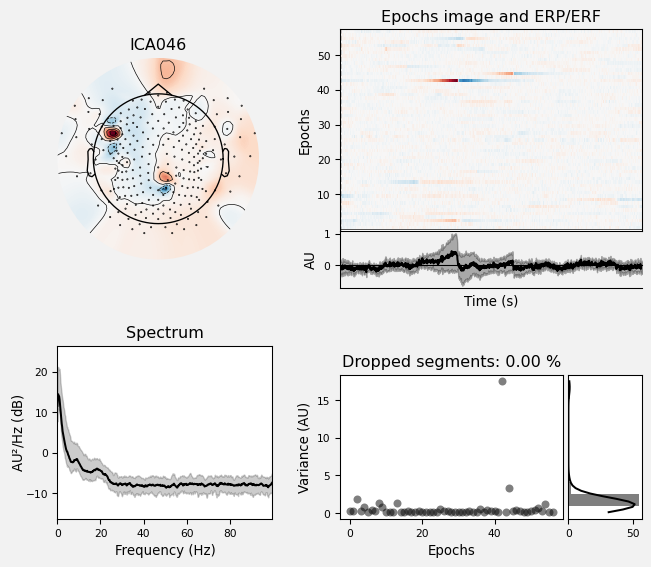

Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


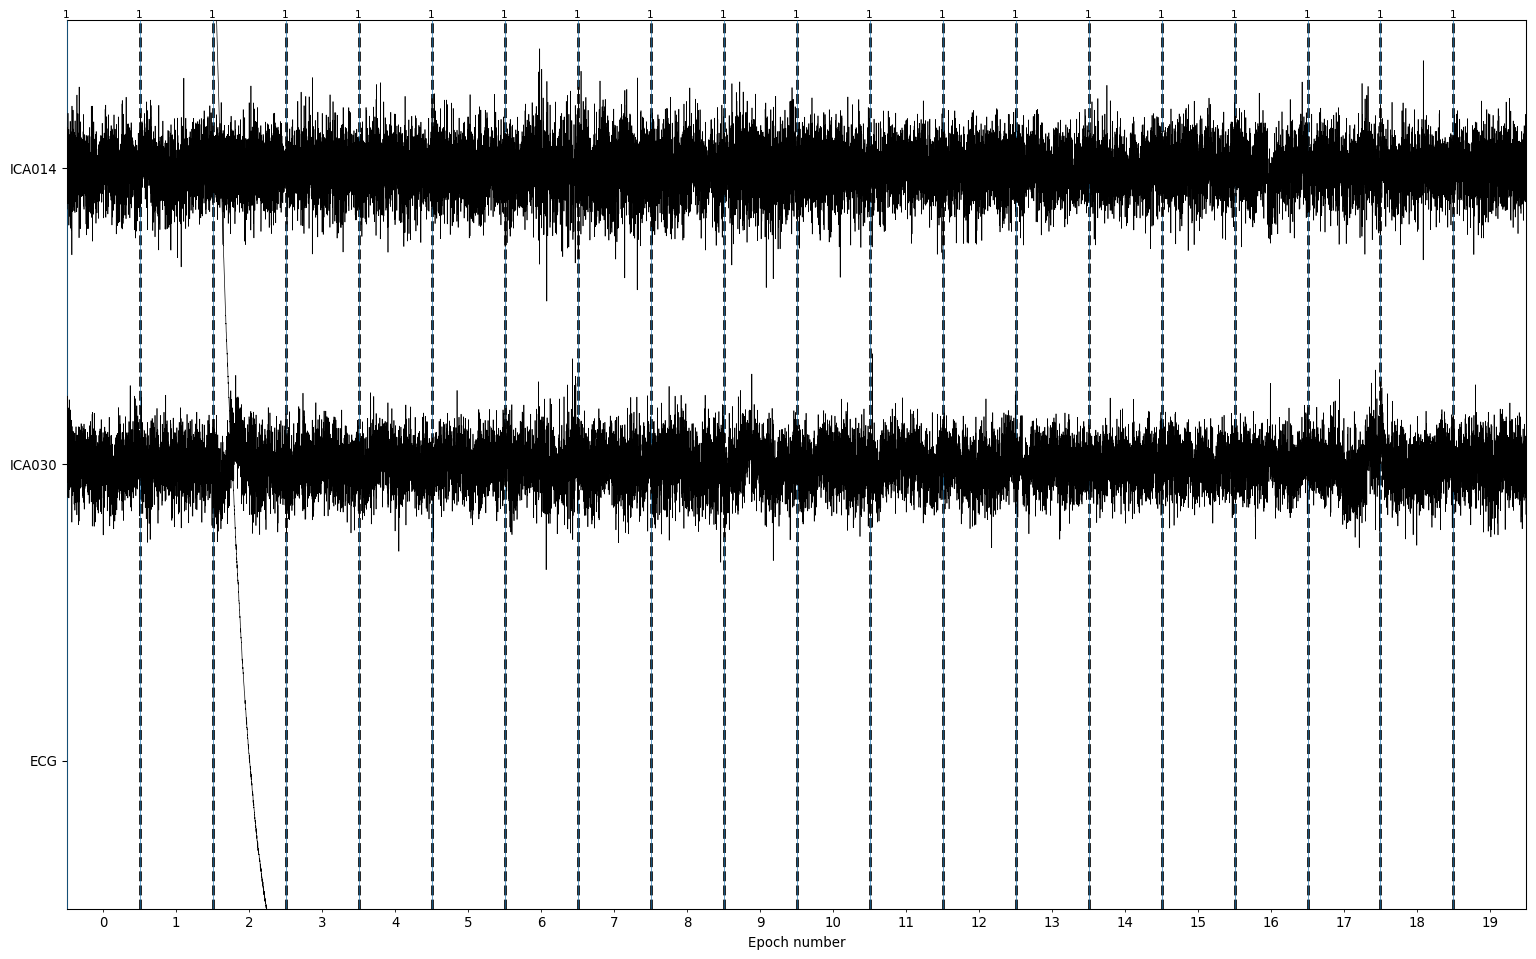

'muscle artifact'

[14, 30]

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


Not setting metadata


57 matching events found


No baseline correction applied


0 projection items activated


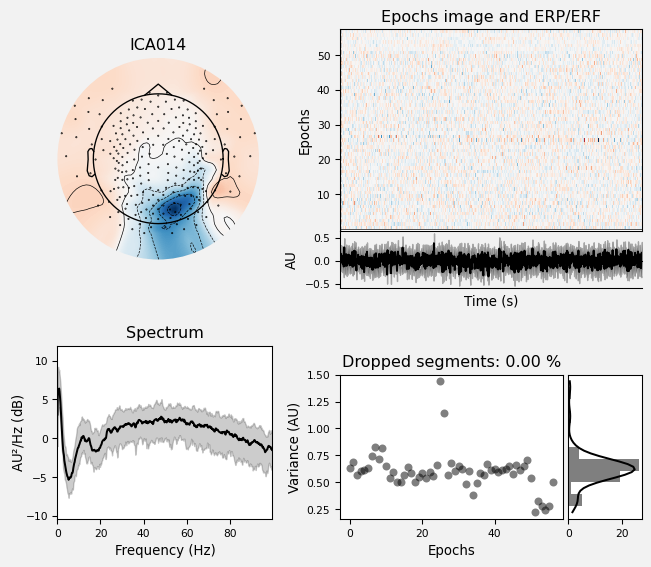

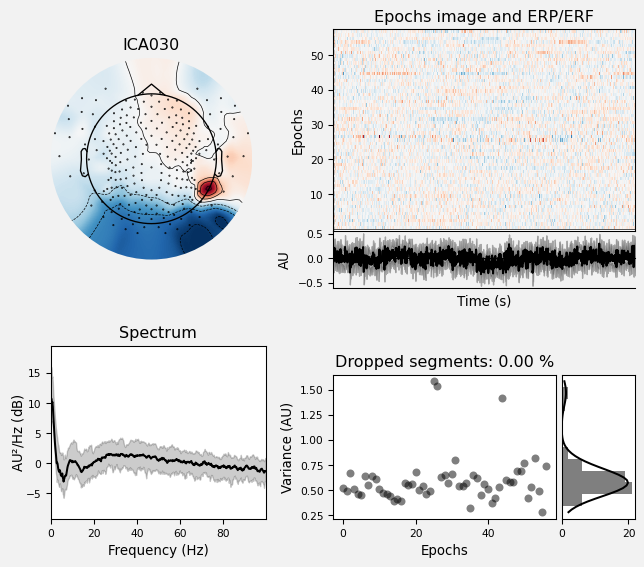

In [9]:
exclude = plot_removed_components(
    ica, epochs, labeled_components, chosen_components=chosen_components
)

Opening raw data file /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-151/raw//sub-151_filtered_zap_eeg.fif...


    Range : 0 ... 147499 =      0.000 ...   294.998 secs


Ready.


Reading 0 ... 147499  =      0.000 ...   294.998 secs...


... filtering ICA sources


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 5000 samples (10.000 s)


... filtering target


Setting up band-pass filter from 8 - 16 Hz


FIR filter parameters


---------------------


Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hann window


- Lower passband edge: 8.00


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)


- Upper passband edge: 16.00 Hz


- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)


- Filter length: 5000 samples (10.000 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata


147 matching events found


No baseline correction applied


0 projection items activated


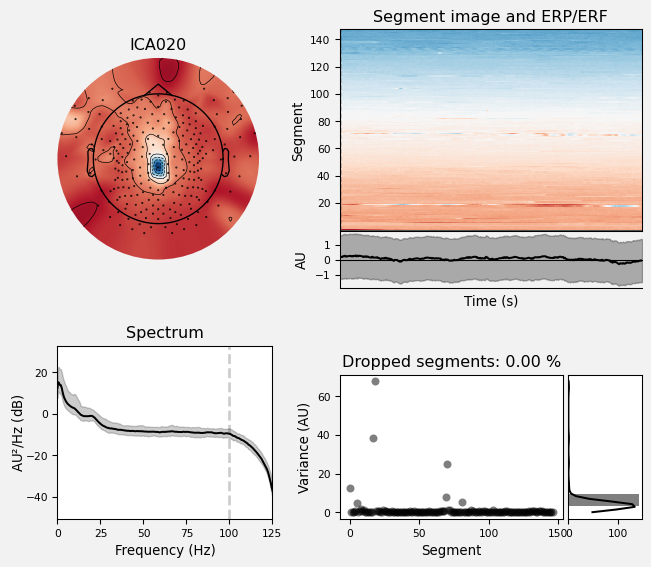

Creating RawArray with float64 data, n_channels=2, n_times=147500


    Range : 0 ... 147499 =      0.000 ...   294.998 secs


Ready.


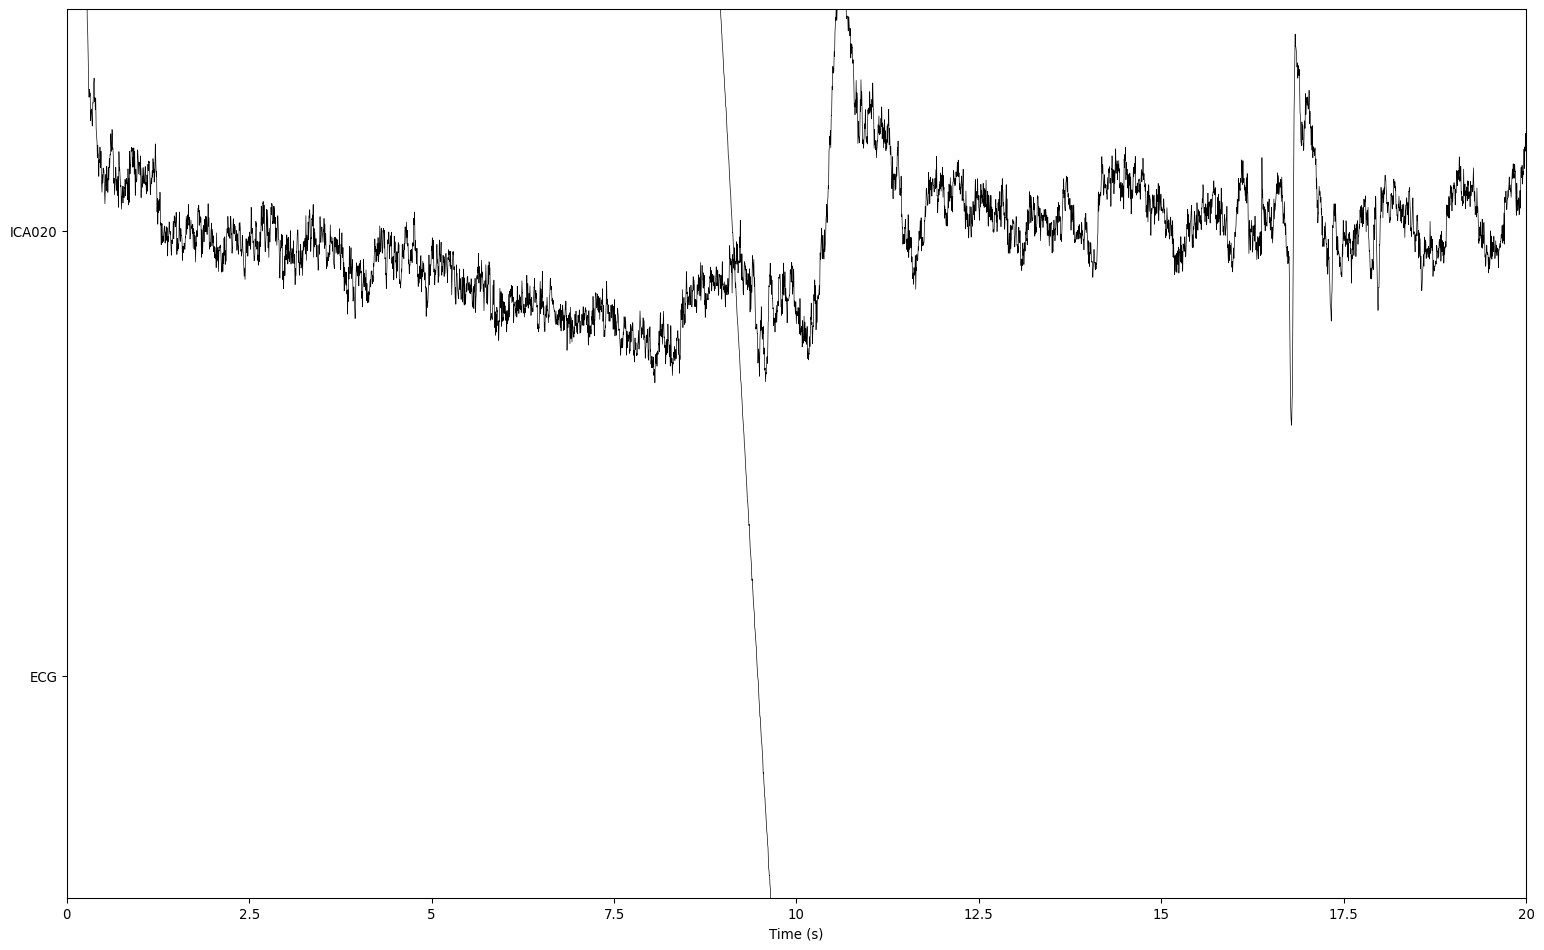

In [10]:
# ica_plot = ica.plot_sources(eeg_data)
# Exclude blink artifact components (use Fp1 as EOG proxy)
clean_raw = mne.io.read_raw_fif(
    f"{preproc_path}/sub-{subject}_filtered_zap_eeg.fif", preload=True
)
# epochs_eog = mne.preprocessing.create_eog_epochs(raw=clean_raw, ch_name="EOG")
# eog_indices, eog_scores = ica.find_bads_eog(epochs_eog, ch_name="E31", threshold=2)
ecg_indices, ecg_scores = ica.find_bads_ecg(
    clean_raw, method="correlation", threshold="auto"
)

# ica.exclude = np.argwhere(abs(eog_scores) > 0.5).ravel().tolist()

# barplot of ICA component "EOG match" scores
ica.plot_properties(clean_raw, picks=ecg_indices)

# plot ICs applied to raw data, with ECG matches highlighted
ecg_plot = ica.plot_sources(
    clean_raw, show_scrollbars=False, picks=ecg_indices)

Applying ICA to Epochs instance


    Transforming to ICA space (47 components)


    Zeroing out 7 ICA components


    Projecting back using 250 PCA components


No projector specified for this dataset. Please consider the method self.add_proj.


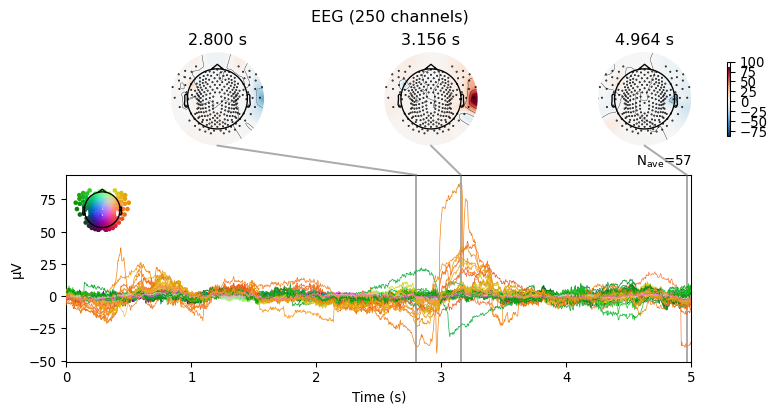

Effective window size : 5.004 (s)


Averaging across epochs...


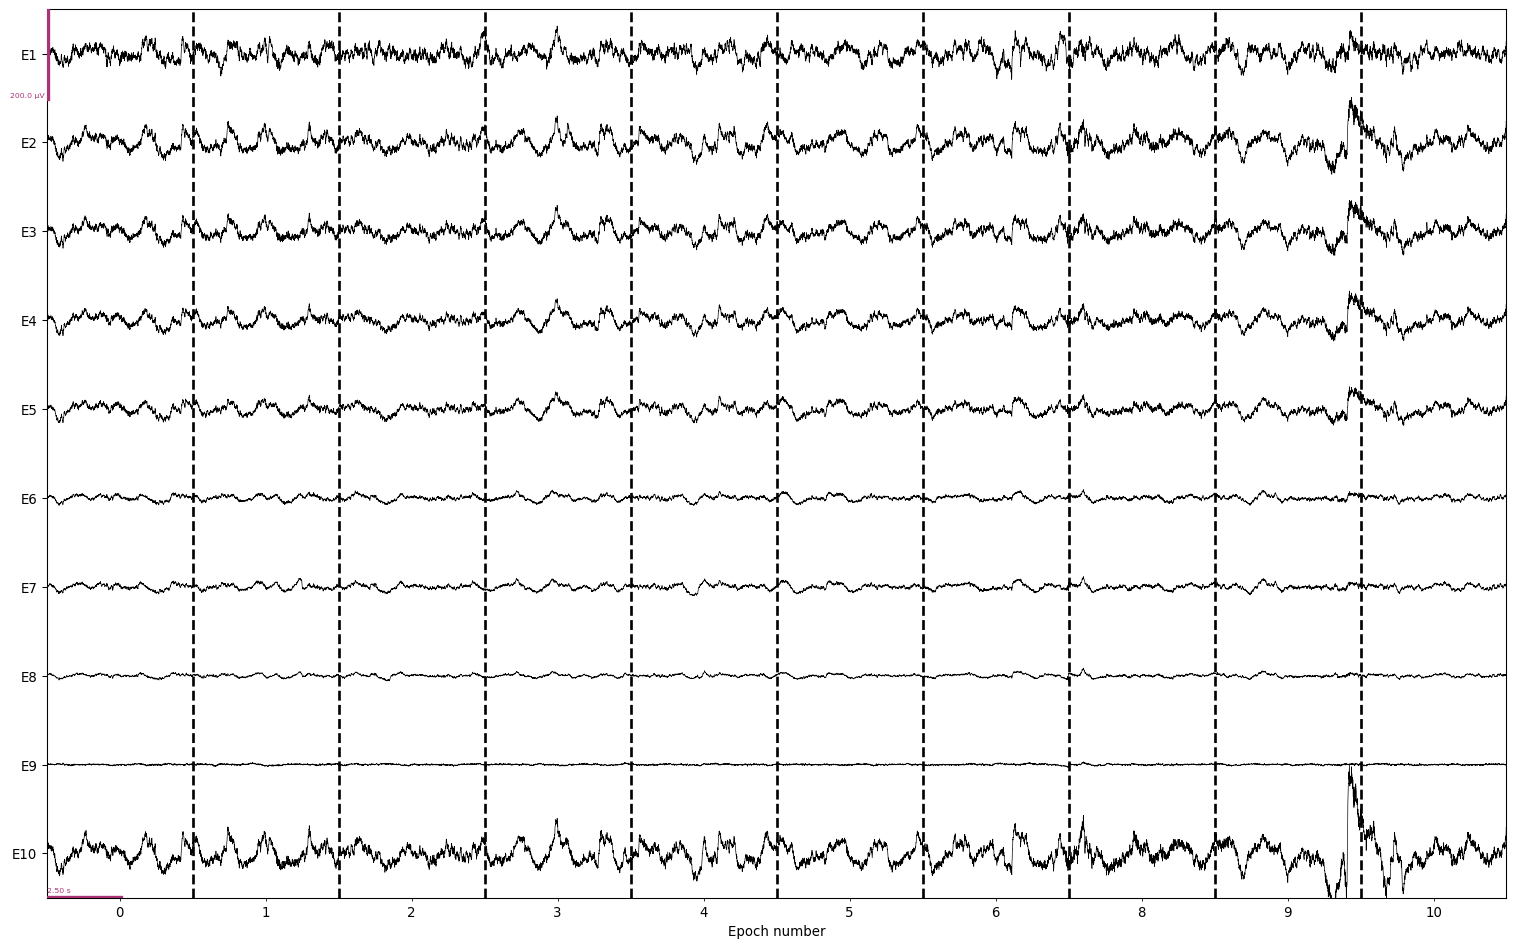

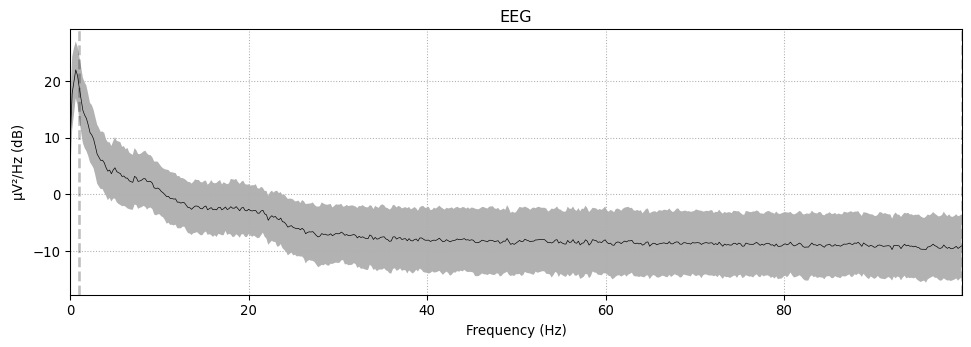

In [11]:
ica.exclude = exclude + ecg_indices
epochs_clean = ica.apply(epochs.copy(), exclude=ica.exclude)
epochs_clean.save(f"{epochs_path}/sub-{subject}_clean_ica-epo.fif", overwrite=True)
epochs_clean_plot = plot_epochs(epochs_clean, stage="epochs_after_ICA")

## Pipeline for ICA with epochs


In [12]:
# reject_log_plot = reject_log.plot_epochs(epochs[reject_log.bad_epochs], scalings=dict(eeg=1e-4))
# with mne.viz.use_browser_backend("qt"):
#    plot_bad_epochs = epochs[reject_log.bad_epochs].plot(
#        scalings=dict(eeg=1e-4))

Instead of applying a high pass filter that can remove a spurious correlation to remove the baseline fluctuations I am using robust detrending using polynomials that ignore outliers [@decheveigne2018RobustDetrendingRereferencing]
Detrending is done twice - first using a line and then a higher-order polynomial to remove faster baseline fluctuations.


# Identifying bad channels


In [13]:
def specparam2pandas(fg):
    """
    Converts a FOOOFGroup object into a pandas DataFrame, with peak parameters and
    corresponding aperiodic fit information.

    Args:
    -----
    fg : specpramGroup
        The FOOOFGroup object containing the fitting results.

    Returns:
    --------
    peaks_df : pandas.DataFrame
        A DataFrame with the peak parameters and corresponding aperiodic fit information.
        The columns are:
        - 'CF': center frequency of each peak
        - 'PW': power of each peak
        - 'BW': bandwidth of each peak
        - 'error': fitting error of the aperiodic component
        - 'r_squared': R-squared value of the aperiodic fit
        - 'exponent': exponent of the aperiodic component
        - 'offset': offset of the aperiodic component
        - 'knee': knee parameter of the aperiodic component [if is initially present in the fg object]
    Notes:
    ------
    This function creates two DataFrames. The first DataFrame `fooof_aperiodic`
    contains the aperiodic fit information and is based on the `aperiodic_params`
    attribute of the FOOOFGroup object. The columns are inferred using the
    `get_ap_indices()` and `infer_ap_func()` functions from the FOOOF package.
    The second DataFrame `peak_df` contains the peak parameters and is based on the
    `peak_params` attribute of the FOOOFGroup object. The column names are renamed
    to match the headers of `fooof_aperiodic`, and the 'ID' column is cast to integer.
    The two DataFrames are then merged based on a shared 'ID' column.
    """

    fooof_aperiodic = (
        pd.DataFrame(
            fg.get_params("aperiodic_params"),
            columns=get_ap_indices(
                infer_ap_func(np.transpose(fg.get_params("aperiodic_params")))
            ),
        )
        .assign(error=fg.get_params("error"), r_squared=fg.get_params("r_squared"))
        .reset_index(names=["ID"])
    )
    return (
        pd.DataFrame(fg.get_params("peak_params"))  # prepare peaks dataframe
        .set_axis(["CF", "PW", "BW", "ID"], axis=1)  # rename cols
        .astype({"ID": int})
        .join(fooof_aperiodic.set_index("ID"), on="ID")
    )

    Using multitaper spectrum estimation with 7 DPSS windows


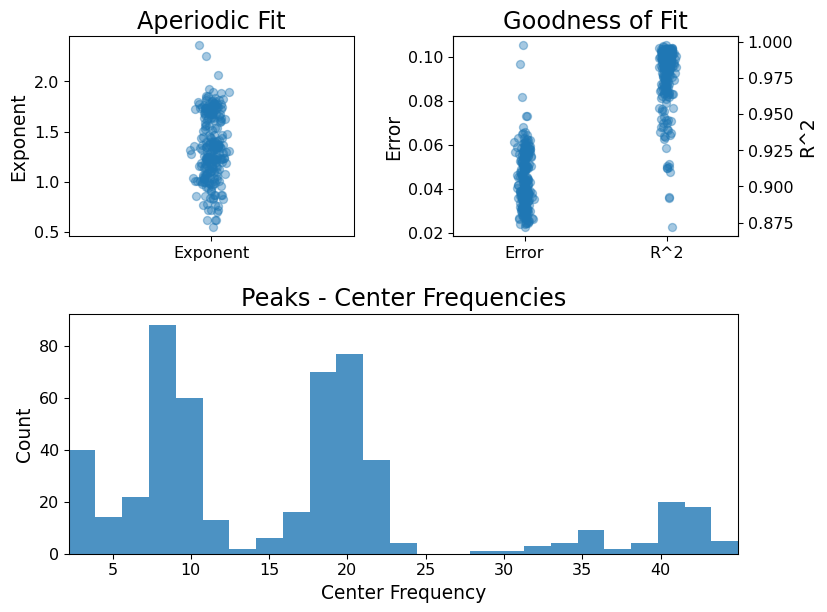

In [14]:
from specparam.plts.spectra import plot_spectra
from specparam import SpectralGroupModel

psd = epochs_clean.compute_psd().average()
spectra, freqs = psd.get_data(return_freqs=True)
# Initialize a FOOOFGroup object, with desired settings


fg = SpectralGroupModel(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

# Define the frequency range to fit
freq_range = [2, 45]
fg.fit(freqs, spectra, freq_range)
fg.plot()

In [15]:
import pandas as pd
from specparam.core.funcs import infer_ap_func
from specparam.core.info import get_ap_indices

df = specparam2pandas(fg)
df.to_csv(f"{path_specparam}/sub-{subject}-specparam.csv", index=False)
print(f"Subject {subject} done")

Subject 151 done
